In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as st
import scipy.signal as signal
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import colormaps as cmaps

# Load data

In [2]:
t_range = pd.date_range(start='01-01-1900', end='12-01-2020', freq='MS')
sst_all = xr.open_dataset('sst.mnmean.nc').sst.sel(time=t_range)
print(sst_all)

<xarray.DataArray 'sst' (time: 1452, lat: 89, lon: 180)>
[23261040 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2020-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]


# Remove trend and seasons

In [3]:
# FUNCTIONS
def demean(x, means):
    means['time'] = x['time']
    return (x - means)


def demean_monthly(da):
    """Removes monthly climatology from each data point."""
    monthly_mean = da.groupby('time.month').mean(dim='time', skipna=True)
    mm = monthly_mean.rename({'month':'time'})
    yearly_groups = da.groupby('time.year')
    da_demeaned = yearly_groups.apply(demean, means=mm)
    
    return da_demeaned


def detrendNaN(y):
    nt = len(y.time)
    t = np.linspace(0, nt-1, nt)
    y_detrend = np.nan*np.ones(y.shape)
    if not np.all(np.isnan(y)):
        m, b, r_val, p_val, std_err = st.linregress(t[~np.isnan(y)],y[~np.isnan(y)])
        y_detrend = y - (m*t + b)
    return y_detrend


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension, slightly different than detrendNaN but much faster
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    coord = da.coords[dim]
    fit = xr.polyval(coord, p.polyfit_coefficients)
    return da - fit


def wrap(data):
    lon_idx = data.dims.index('lon')
    wrap_data, wrap_lon = add_cyclic_point(data.values, coord=data.lon, axis=lon_idx)
    wrapped = xr.DataArray(data=wrap_data,
                           coords={'time': data.time, 'lat': data.lat, 'lon': wrap_lon},
                           dims=data.dims)
    return wrapped

In [4]:
detrended = detrend_dim(sst_all, dim='time')
sst = wrap(demean_monthly(detrended))

/Applications/anaconda3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


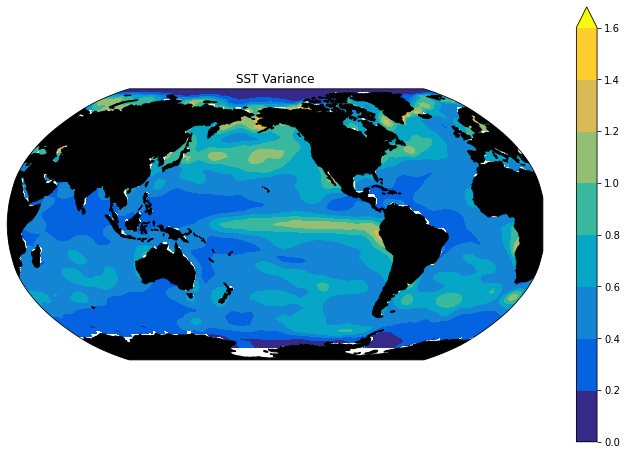

In [5]:
std = sst.std(dim='time')
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=210))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1)
std.plot.contourf(vmin=0, vmax=1.6, levels=9, transform=ccrs.PlateCarree(), cmap=cmaps.parula)
plt.title('SST Variance')
plt.show()

# EOF Analysis

In [6]:
def run_EOF(sst, region, nmodes=3):
    """
    Run EOF analysis on SST data from the chosen region.
    """
    regions = {
        'whole': [90, -90, 0, 360],
        'enso': [10, -10, 120, 280],
        'tropical_pacific': [30, -30, 110, 280],
        'global_pacific': [87, -87, 1, 285],
        'atlantic': [80, -20, 285, 357],
        'pacific_pdo': [65, 20, 120, 260],
        'tropics': [20, -20, 1, 357],
        'global': [65, -65, 1, 357],
        'north_indian': [40, -20, 45, 105],
        'pacific_65': [65, -65, 120, 255]
    }
    
    # Weight by sqrt cos lat so that variance is weighted by cos lat
    lat_wts = np.sqrt(np.cos(sst.lat*np.pi/180))
    sst_weighted = lat_wts * sst

    # Select Region
    [latN, latS, lonW, lonE] = regions[region]
    lat_range = slice(latN,latS)
    lon_range = slice(lonW,lonE)
    sst_reg = sst_weighted.sel(lat=lat_range, lon=lon_range)

    # Estimate autocorrelation
    ss = sst_reg.stack(ind=('lat', 'lon')).T  # want time to be second dimension
    NT = len(ss.time)
    aa = np.diag(np.matmul(ss.values, ss.T.values))/NT
    np.testing.assert_allclose(aa, ss.var(dim='time').values)

    d1 = ss[:, 0:NT-1]
    d2 = ss[:, 1:NT]
    ab = np.diag(np.matmul(d1.values, d2.values.T))/(NT-1)
    # ab1 = xr.cov(d1, d2, dim='time', ddof=1).values  # This is different for some reason?

    ac = np.divide(ab, aa)
    autt = np.nanmean(np.multiply(ac, aa)) / np.nanmean(aa)
    dof = NT * (1-autt*autt) / (1+autt*autt)

    U, S, V = np.linalg.svd(ss.fillna(0))
    sd = np.square(S)/len(ss.ind)
    sd = sd / np.sum(sd) * 100

    factor = np.sqrt(2/dof)
    sd_err = sd * factor

    nn = 12

    xs = np.arange(0, len(sd))
    fig = plt.figure(figsize=(12, 8))
    plt.errorbar(xs[0:nn], sd[0:nn], yerr=sd_err[0:nn], ecolor='k', capsize=5, lw=2, barsabove=True)

    plt.title(f'{region} Eigenvalue Spectrum')
    plt.xlabel('Index')
    plt.ylabel('Percent Variance Explained')

    plt.show()

    ivmax = nmodes

    for i in range(ivmax):  # Only i=0 is significant and physically meaningful
        pc_raw = V[i, :]  # rows of V are pcs
        pc = (pc_raw - np.mean(pc_raw)) / np.std(pc_raw)
        if i == 1 and region == 'pacific_65':
            pc = -pc  # arbitrary sign difference
        pc_da = xr.DataArray(pc, coords={'time': sst.time}, dims=['time'])

        # Filter PCs
        Wn = 1/36
        nf = 7
        b, a = signal.butter(nf, Wn)
        pcf = signal.filtfilt(b, a, pc)

        # Plot PC
        xs = ss.time.values
        fig = plt.figure(figsize=(12, 6))
        plt.title(f'{region}: PC {i+1}')
        plt.ylabel('PC Amplitude')
        plt.plot(xs, pc, xs, pcf)
        plt.show()


        # Regress
        regr = sst_weighted.dot(pc_da, dims='time') / NT

        # Plot Regression
        fig1 = plt.figure(figsize=(12, 8))
        ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=210))
        ax.add_feature(cfeature.LAND, facecolor='k', zorder=1)
        im = regr.plot.contourf(levels=9, cmap=cmaps.parula, transform=ccrs.PlateCarree(), add_colorbar=0)
        cbar = plt.colorbar(im, ax=ax, fraction=0.02,pad=0.02)
        cbar.set_label('SST Anomaly ($^\circ$C)')
        plt.title(f'{region} SST: Regression Mode {i+1}')
        plt.show()

# Results

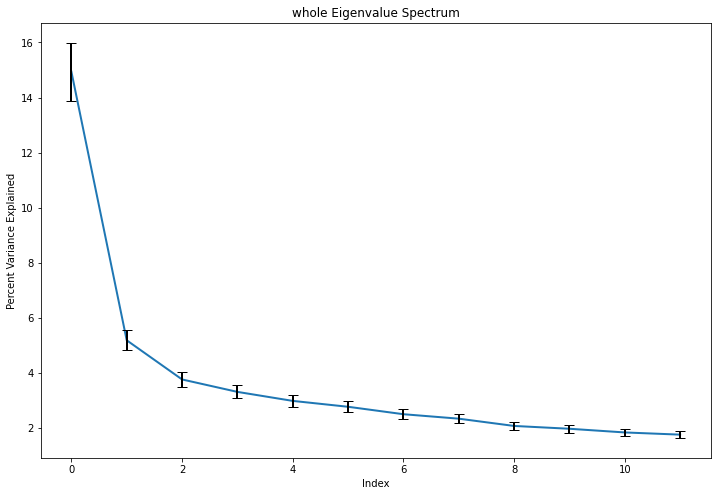

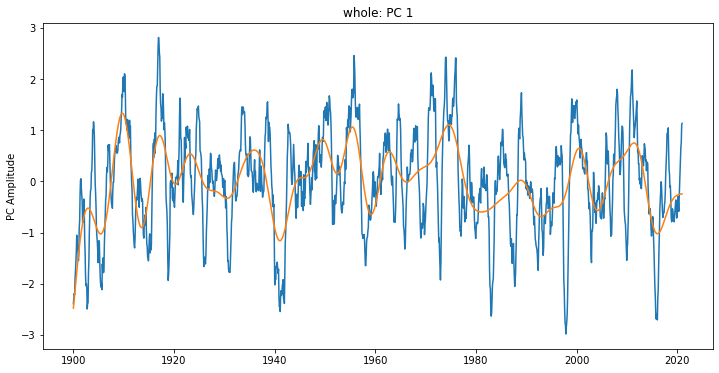

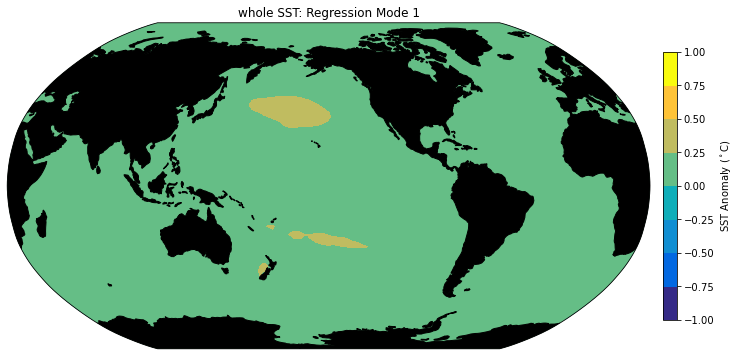

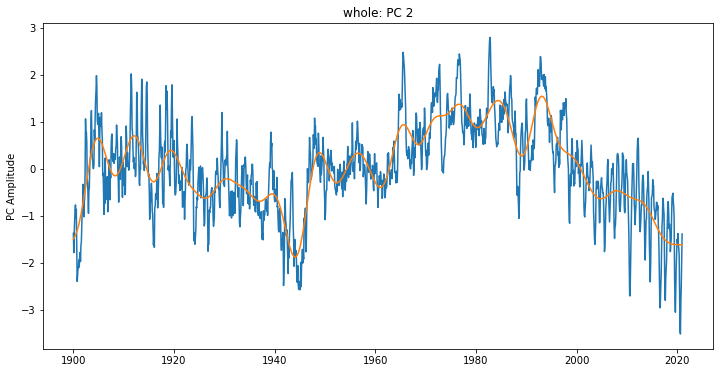

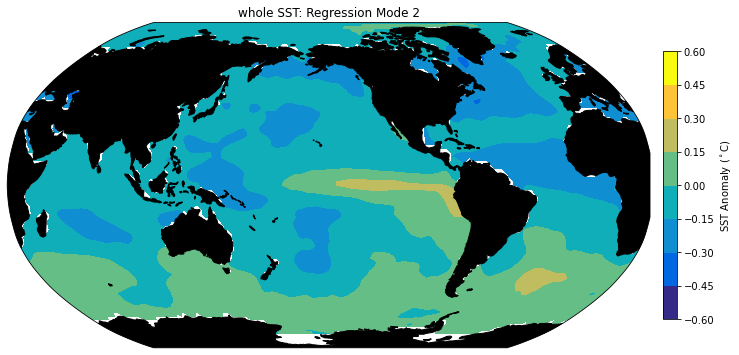

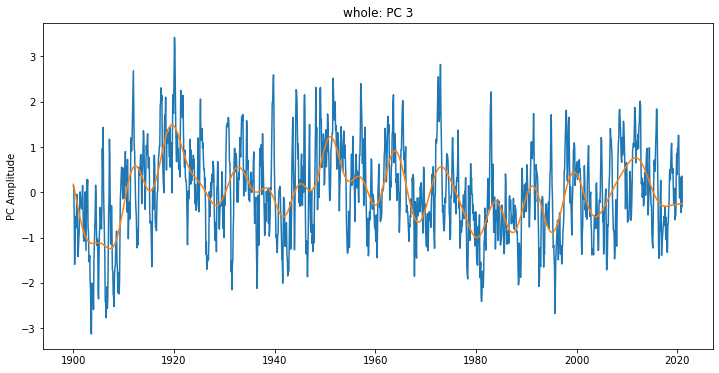

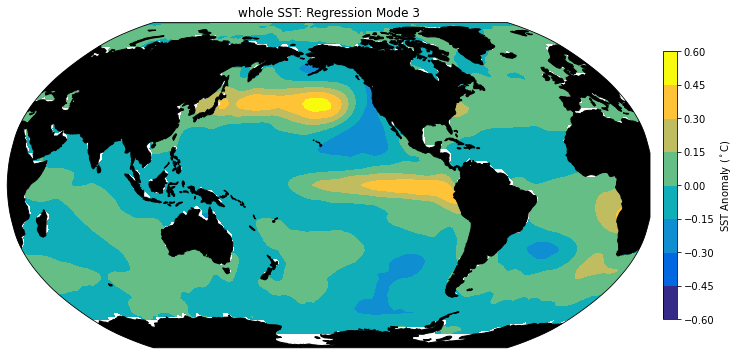

In [7]:
run_EOF(sst, 'whole')

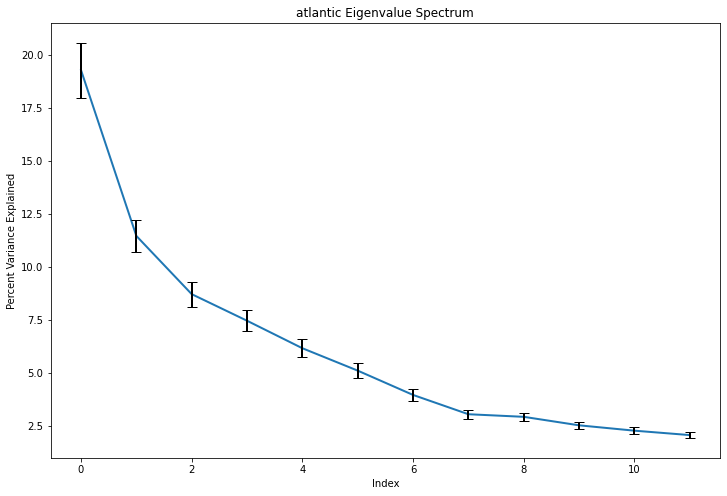

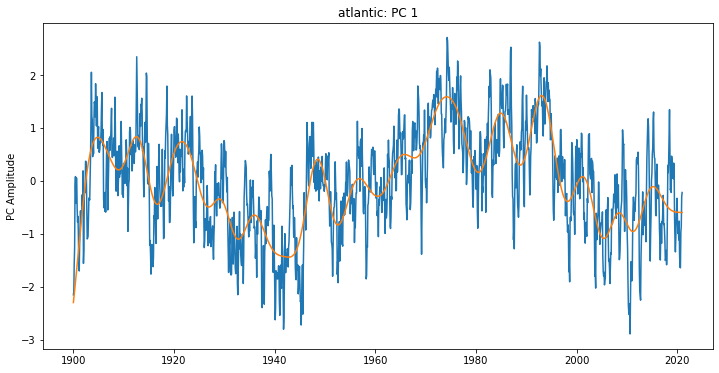

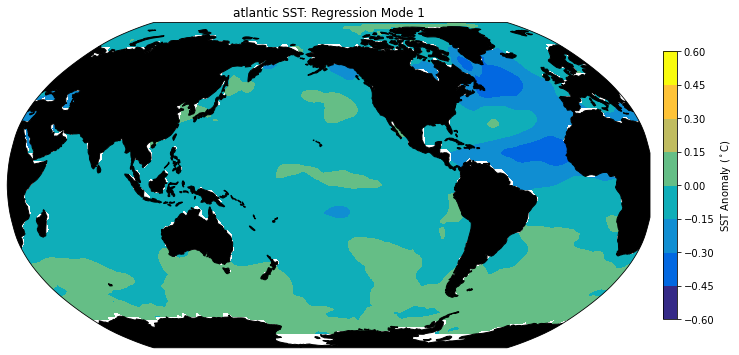

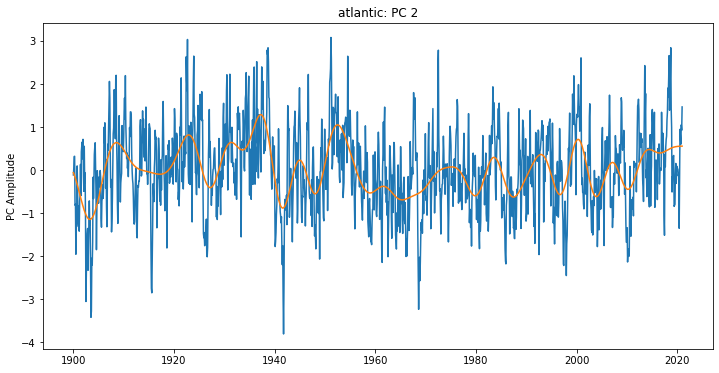

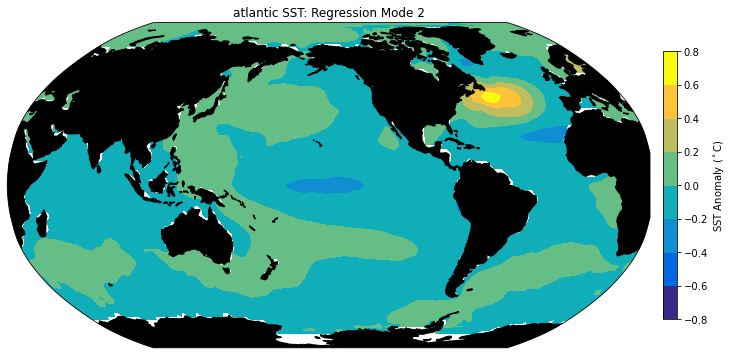

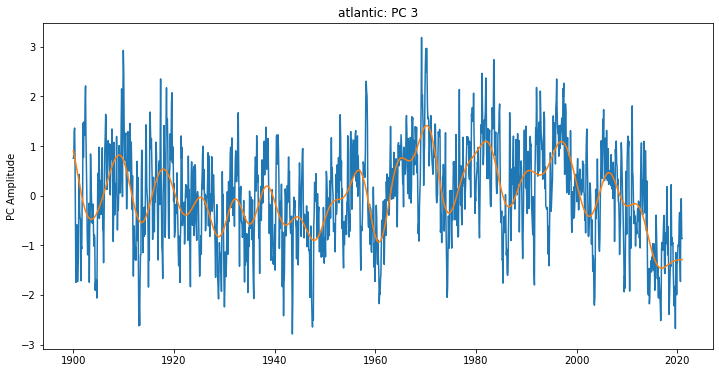

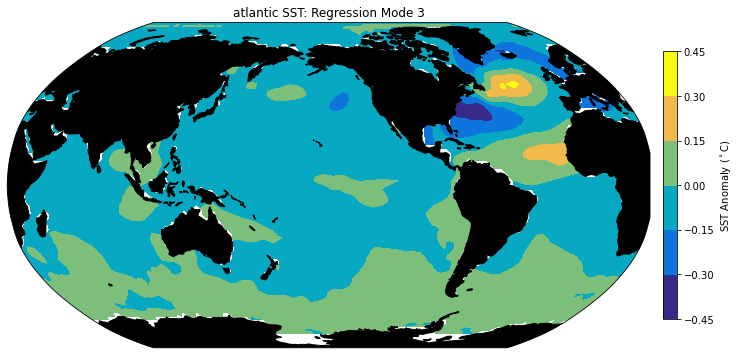

In [8]:
run_EOF(sst, 'atlantic')

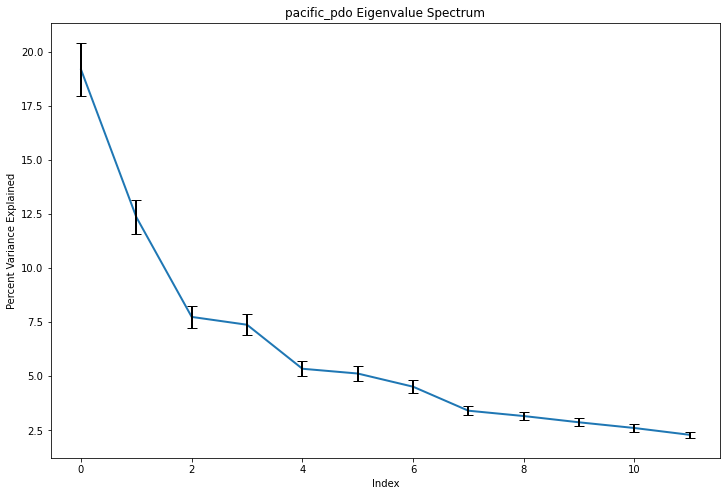

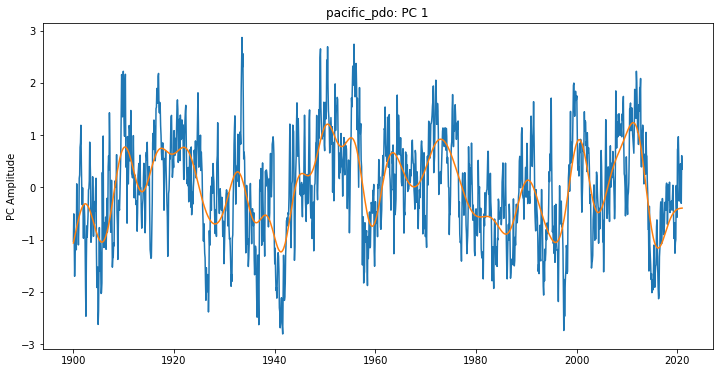

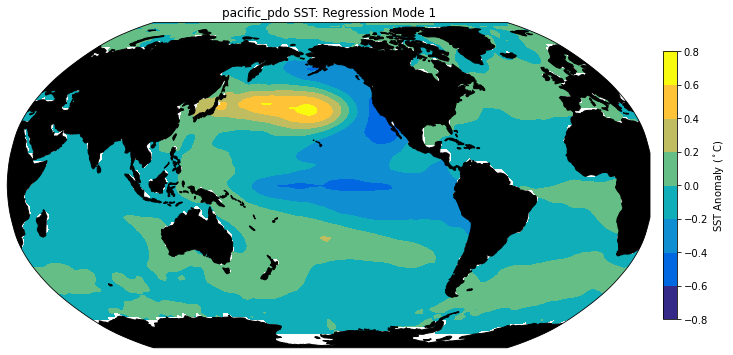

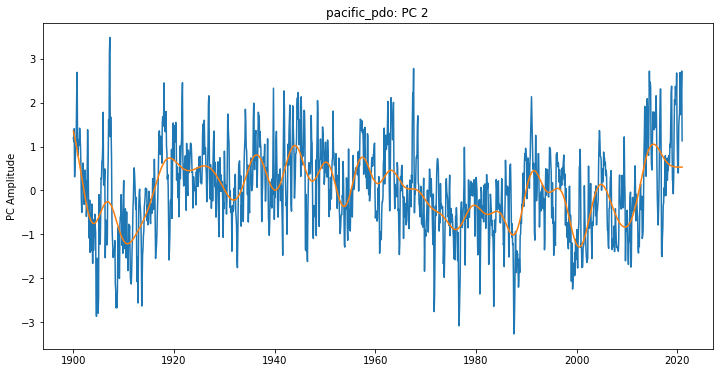

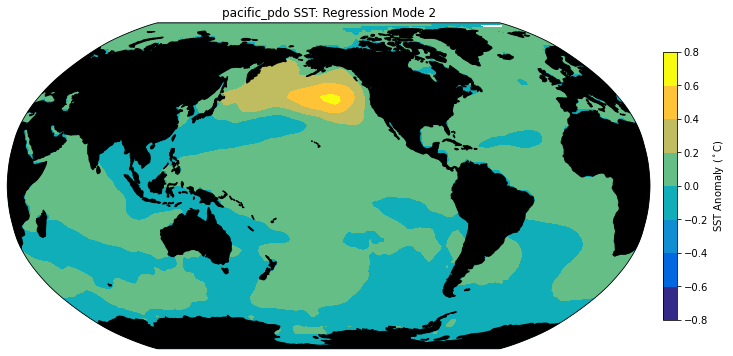

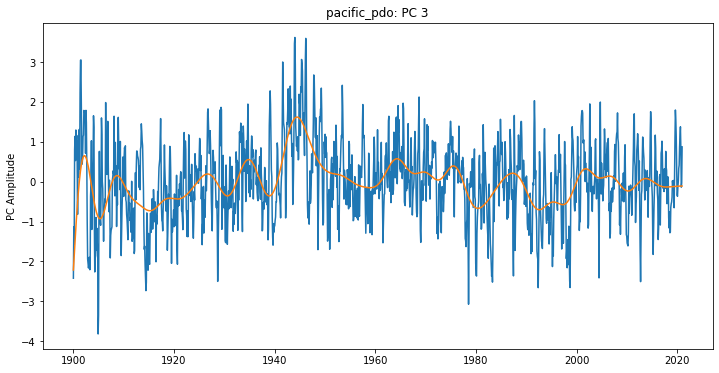

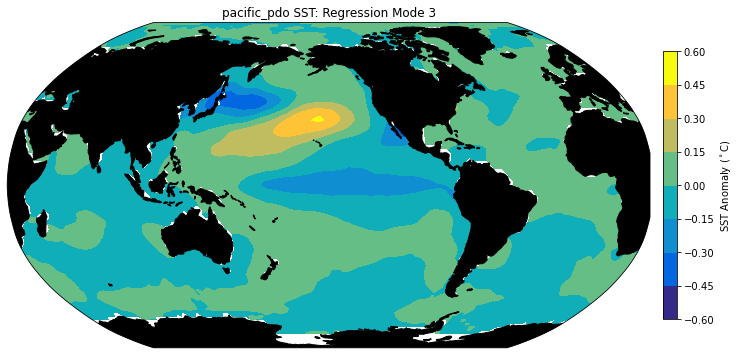

In [9]:
run_EOF(sst, 'pacific_pdo')

# Discussion

When looking at the whole global ocean, the first two modes seem physically significant. The first resembles the overall global SST pattern and is fairly spatially uniform, and the second and third modes resemble ENSO SST patterns.

When we run the EOF analysis on just the Atlantic SSTs, again the first two modes pass the North test for significance. Here, the first mode looks like the subpolar and suptropical gyres oscillating together, and the second mode indicates warming in the NW Atlantic. Both of these resemble physical areas of the Atlantic and make sense to have physical meaning.

When we consider just the Pacific PDO region (20N-65N) the first two modes represent physical processes. The first mode is El Niño while the second mode shows strong warming in the subpolar North Pacific, a signal of recent marine heatwaves. I didn't expect that marine heatwave signal to be so clear, but there are spikes in the unsmoothed PC timeseries in some of the expected years.